In [23]:
import numpy as np
import os
import cv2
from PIL import Image
import keras
np.random.seed(1000)
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [27]:

SIZE = 64
dataset = []
label = []

parasitized_images = os.listdir('Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread('Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

uninfected_images = os.listdir('Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread('Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)
        
print(len(dataset))

27558


In [30]:
# defining the cnn model

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [31]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib import pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 5,
                         validation_split = 0.1,
                         shuffle = False)

Epoch 1/5
311/311 [==============================] - 18s 57ms/step - loss: 0.5200 - accuracy: 0.7685 - val_loss: 0.6496 - val_accuracy: 0.7256
Epoch 2/5
311/311 [==============================] - 18s 57ms/step - loss: 0.2456 - accuracy: 0.9086 - val_loss: 0.4264 - val_accuracy: 0.8739
Epoch 3/5
311/311 [==============================] - 23s 74ms/step - loss: 0.1948 - accuracy: 0.9284 - val_loss: 0.3998 - val_accuracy: 0.8821
Epoch 4/5
311/311 [==============================] - 18s 58ms/step - loss: 0.1712 - accuracy: 0.9373 - val_loss: 0.3042 - val_accuracy: 0.9215
Epoch 5/5
311/311 [==============================] - 18s 57ms/step - loss: 0.1475 - accuracy: 0.9450 - val_loss: 0.2088 - val_accuracy: 0.9320


173/173 [==============================] - 2s 9ms/step - loss: 0.1856 - accuracy: 0.9385
Test_Accuracy: 93.85%


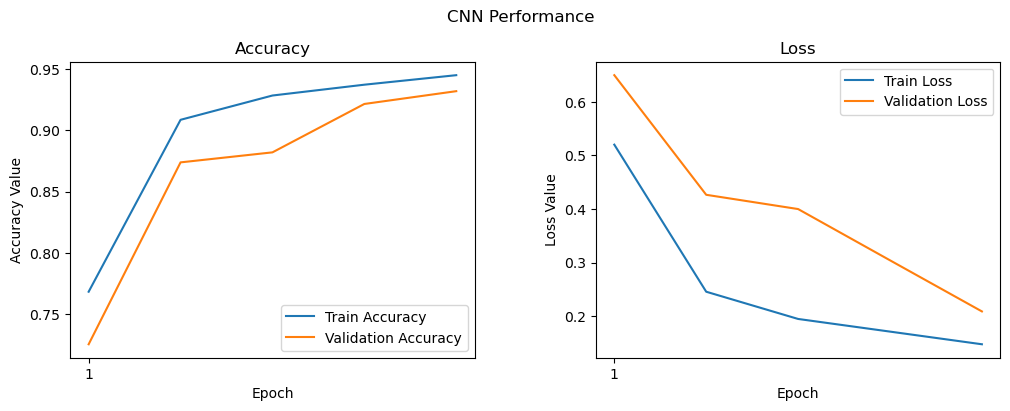

In [32]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))




f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [49]:
y_pred = model.predict(np.array(X_test))

173/173 [==============================] - 1s 8ms/step


In [51]:
y_pred = (y_pred > 0.5).astype(int)

In [52]:
y_test = y_test.astype(int)
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_pred,y_test)

# Print the confusion matrices for each label
for i, label_cm in enumerate(cm):
    print(f"Confusion Matrix for Label {i}:\n{label_cm}\n")

Confusion Matrix for Label 0:
[[2759  338]
 [  50 2365]]

Confusion Matrix for Label 1:
[[2444   93]
 [ 259 2716]]

